# **Interpretability of Neural Networks for model selection**
## Primordial Feature template vs ΛCDM at the level of the CMB angular power spectrum - $\mathcal{C}^{TT}_{\ell}$ data
### Assess the NN learning process with [explainable AI with Shapley values](https://github.com/shap/shap.git)
### Which features is the NN actually learning when differentiating a primoridal feature template model and ΛCDM?
**Find the documentation [here](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).**

In [1]:
#Import packages
import pandas as pd
import numpy as np
import math 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers.experimental.preprocessing import Normalization
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam

### Read and visualize the data (simulated out of [CLASS](https://github.com/lesgourg/class_public) and the [ESA Planck Archival](https://pla.esac.esa.int/#home))

In [2]:
#Read the data
PS = '_TTcls'
label_Ax0 = 'Ax_e-2'
planck_df_LCDM = np.genfromtxt('./simulated_data/TT_polarization/clsTT_LCDM_noisy.csv', delimiter=',')
planck_df_MoG = np.genfromtxt('./simulated_data/TT_polarization/clsTT_Feature_noisy%s.csv'%label_Ax0, delimiter=',')
ls_planck = planck_df_LCDM[0]
planck_cls_LCDM = planck_df_LCDM[1:] # get rid of the first column, i.e. multipole moment l
planck_cls_MoG = planck_df_MoG[1:]
ls = planck_df_LCDM[0]

#Add the model class: 
LCDM_class = np.zeros(len(planck_cls_LCDM))
MoG_class = np.ones(len(planck_cls_MoG))

#Full arrays (+target):
cls_LCDM_class = np.column_stack((planck_cls_LCDM, LCDM_class))
cls_MoG_class = np.column_stack((planck_cls_MoG, MoG_class))

#Full data set (LCDM + MoG)
cls_full_dataset = np.concatenate((planck_cls_LCDM, planck_cls_MoG)) #without the class: x_dataset
dataset_class = np.concatenate((LCDM_class, MoG_class)) #only the class: y_dataset
cls_full_dataset_class = np.concatenate((cls_LCDM_class, cls_MoG_class)) #with the class: xy_dataset

In [3]:
#-----------------------------------------------------------------------------------------------------------------------
#Dls
#-----------------------------------------------------------------------------------------------------------------------
# Create a function for converting the C_ls^TT to Dls Tcmb=2.7255
def Dls(l,CTT):
    Dl = [l[i]*(l[i]+1)*CTT[i]/((2*math.pi)*(2.7255*10**6)**2) for i in range(len(l))]
    return Dl
#-----------------------------------------------------------------------------------------------------------------------

### Z-score normalization of the $\mathcal{C}^{TT}_{\ell}$ data

In [4]:
#-------------------------------------------------------------------------------------------------------------
#Normalization and visualization
#-------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
normalize = Normalization()
normalize.adapt(cls_full_dataset)
normalized_data = normalize(cls_full_dataset)

#Z-SCORE verification
print('var: %.4f' % np.var(normalized_data))
print('mean: %.4f' % np.mean(normalized_data))

var: 1.0000
mean: 0.0000


<Figure size 800x600 with 0 Axes>

### Training the neural networks

In [5]:
#Train_test_split
from sklearn.model_selection import train_test_split
normalized_data_numpy = normalized_data.numpy()
X_train, X_test, y_train, y_test = train_test_split(normalized_data_numpy, dataset_class, test_size=0.3, random_state=42)
#Training and validation split with fixed random seed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
#Redefine the model's architecture to display the input layer: (functional API)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

inputs = Input(shape=(len(normalized_data[0]),), name='input_layer') #shape=X_train.shape[1],
hidden_layer = Dense(32, activation='relu', name='hidden_layer')(inputs)
dropout_layer = Dropout(rate=0.2, name='dropout_layer')(hidden_layer)
outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout_layer)

#Create the model
model = Model(inputs=inputs, outputs=outputs, name='Angular_PS_NN')

#Model details
model.summary()

Model: "Angular_PS_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 83)]              0         
                                                                 
 hidden_layer (Dense)        (None, 32)                2688      
                                                                 
 dropout_layer (Dropout)     (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2721 (10.63 KB)
Trainable params: 2721 (10.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
#-----------------------------------------------------------------------------------------------------------
#Training the NN
#-----------------------------------------------------------------------------------------------------------
model.reset_states()
#Compile model:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

#Training:
History = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/1000
18/18 [==============================] - 1s 13ms/step - loss: 0.8843 - accuracy: 0.4911 - val_loss: 0.7834 - val_accuracy: 0.5071
Epoch 2/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.8189 - accuracy: 0.4732 - val_loss: 0.7229 - val_accuracy: 0.5357
Epoch 3/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.7564 - accuracy: 0.4893 - val_loss: 0.7041 - val_accuracy: 0.4714
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.7465 - accuracy: 0.5179 - val_loss: 0.7001 - val_accuracy: 0.5500
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.7412 - accuracy: 0.5036 - val_loss: 0.6982 - val_accuracy: 0.5357
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.7440 - accuracy: 0.4839 - val_loss: 0.6963 - val_accuracy: 0.5357
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5464 - val_loss: 0.6923 - val_accuracy: 0.5429
Epoch

## Interpretability using [SHAP (SHapley Additive exPlanations)](https://github.com/shap/shap.git)

In [8]:
%%capture
#-----------------------------------------------------------------------------------------------------------
#Interpretability 
#-----------------------------------------------------------------------------------------------------------
import shap
X100 = shap.utils.sample(X_train, 100); #100 instances as the background distribution

# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100);
shap_values = explainer(X_train);

print('SHAP values were succesfully calculated')

### Shap values and the prectiction (ΛCDM or Feature) for each realization:

#### Local Interpretability plots

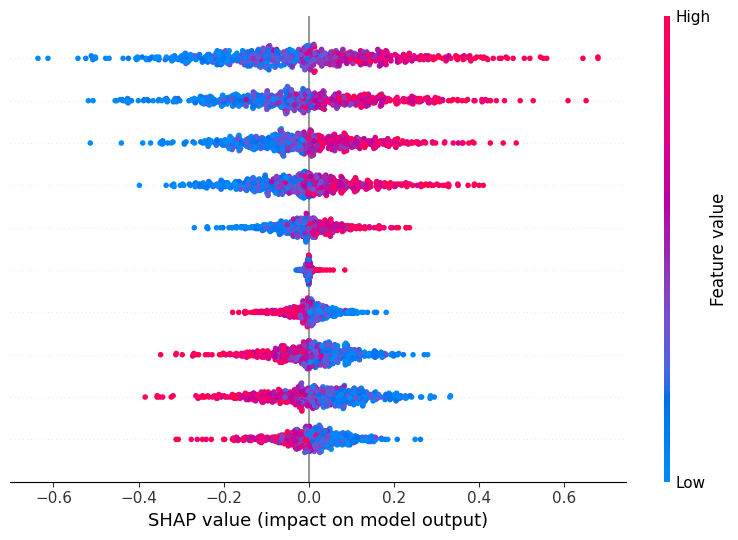

In [9]:
#Summary plot (default by shap)
shap.summary_plot(shap_values, X_train, sort=False, max_display=10, plot_type="dot", feature_names=[""] * X_train.shape[1], color_bar=True)

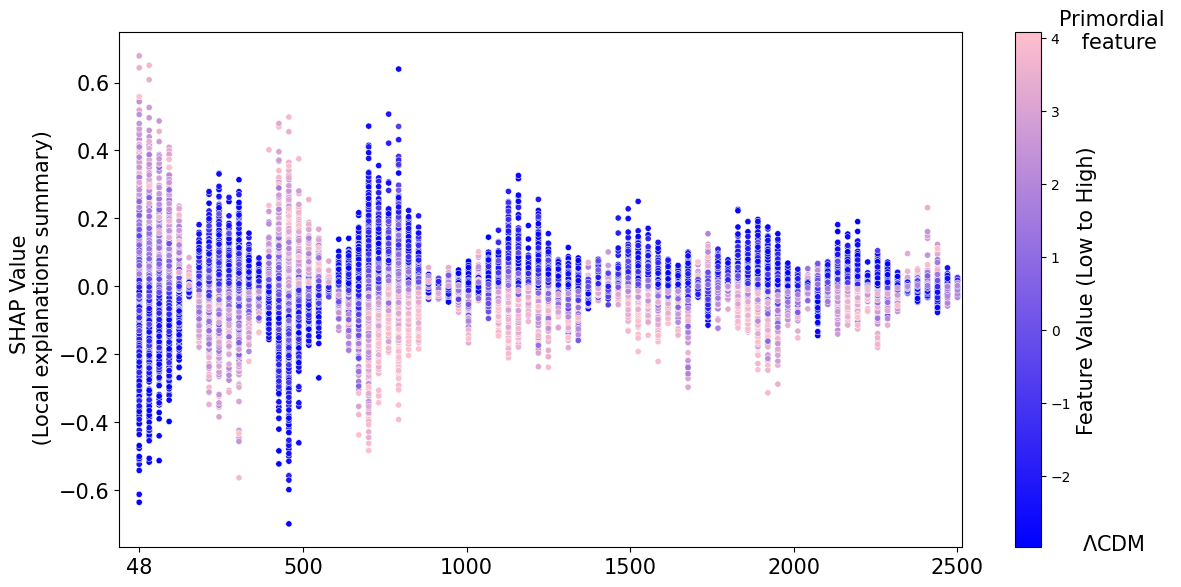

In [20]:
#Customized plot
import matplotlib.colors as mcolors
import seaborn as sns

shap_values_array = shap_values.values  #SHAP values for each feature
feature_data = shap_values.data         #Original feature values
fsize = 15

#Number of features
n_features = shap_values_array.shape[1]

#Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Add color bar to represent feature values
norm = plt.Normalize(vmin=feature_data.min(), vmax=feature_data.max())
colors = [(0, 0, 1), (1, 0.75, 0.8)]  #Blue to pink
cmap = mcolors.LinearSegmentedColormap.from_list("blue_pink", colors)

for i in range(n_features):
    # Scatter plot: x = SHAP value, y = feature index (i), color = feature value
    sns.scatterplot(
        x=np.ones_like(shap_values_array[:, i]) * i,  # SHAP_value for feature i
        y=shap_values_array[:, i], 
        hue=feature_data[:, i], 
        palette=cmap, 
        legend=False, 
        s=20,
        ax=ax
    )

num_ticks = 6  
x_ticks = np.array([ls_planck[0], 500, 1000, 1500, 2000, 2500])
ax.set_xticks(np.linspace(0, n_features - 1, num_ticks))
ax.set_xticklabels([f"{int(tick)}" for tick in x_ticks], fontsize=fsize)

ax.set_xlim(-2, 82.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label('Feature Value (Low to High)', fontsize=fsize)
cbar.ax.text(3.9, 3.8, 'Primordial \n feature', ha='center', va='bottom', fontsize=fsize)
cbar.ax.text(3.8, -2.8, '$\Lambda$CDM', ha='center', va='top', fontsize=fsize)

#ax.set_xlabel("$\ell$", fontsize=fsize)
ax.set_ylabel("SHAP Value \n (Local explanations summary)", fontsize=fsize)
ax.tick_params(labelsize=fsize)

plt.tight_layout()
plt.savefig('./figures_feature/Shap_Local_Interpretability_Summary_Feature.pdf')
plt.show()

### Global interpretability plots

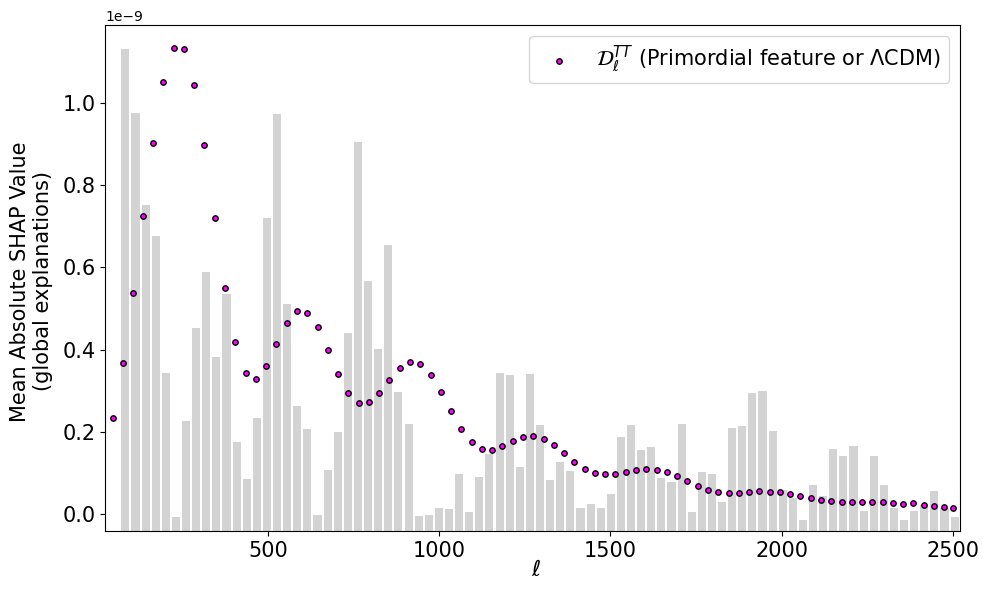

In [11]:
mean_abs_shap_values = np.mean(np.abs(shap_values_array), axis=0)
n_features = shap_values_array.shape[1]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.axis("off")

#Plot 1: vertical bars for global feature importance
ax1 = fig.add_subplot()
ax1.bar(
    range(len(ls_planck)),
    mean_abs_shap_values[range(len(ls_planck))], 
    color='lightgray',  #Set bar color
)
ax1.set_xlim(-2,82.5)
ax1.set_xticks([])  
ax1.set_yticks([])  

ax1.set_ylabel('Mean Absolute SHAP Value \n(global explanations) \n \n', fontsize=fsize)
ax1.set_xlabel('\n $\ell$', fontsize=fsize+1)

# PLOT 2: Planck-like data for Feature vs LCDM
ax2 = fig.add_subplot(frame_on=False)
ax2.scatter(ls_planck, Dls(ls_planck,planck_df_MoG[1]), s=15, label='$\mathcal{D}^{TT}_{\ell}$ (Primordial feature or $\Lambda$CDM)', color='magenta', edgecolors='black')
ax2.tick_params(axis='x', labelsize=fsize)
ax2.tick_params(axis='y', labelsize=fsize)
ax2.legend(fontsize=fsize)
ax2.set_xlim(25,2520)

plt.tight_layout()
plt.savefig('./figures_feature/Shap_Global_Interpretability_Summary_Feature.pdf')
plt.show()

### Partial dependence plots 

4/4 [==============================] - 0s 3ms/step


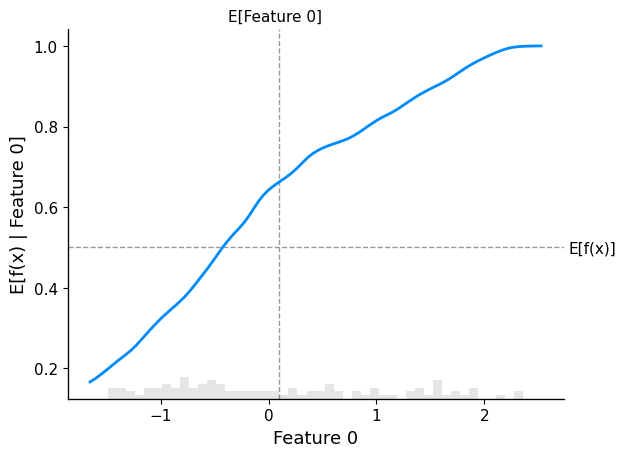

In [12]:
# make a standard partial dependence plot  
sample_ind = 5

shap.partial_dependence_plot(
    0,
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

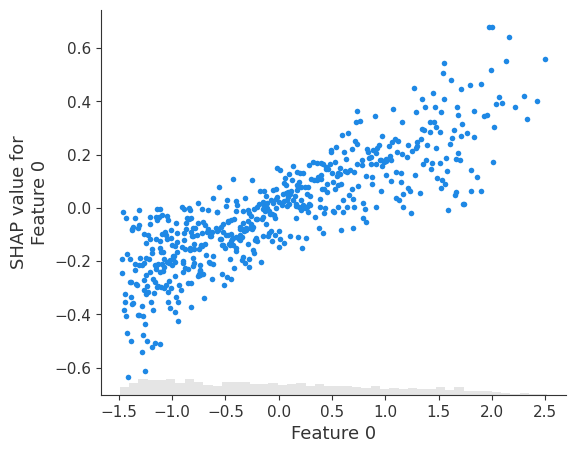

In [13]:
shap.plots.scatter(shap_values[:, 0])

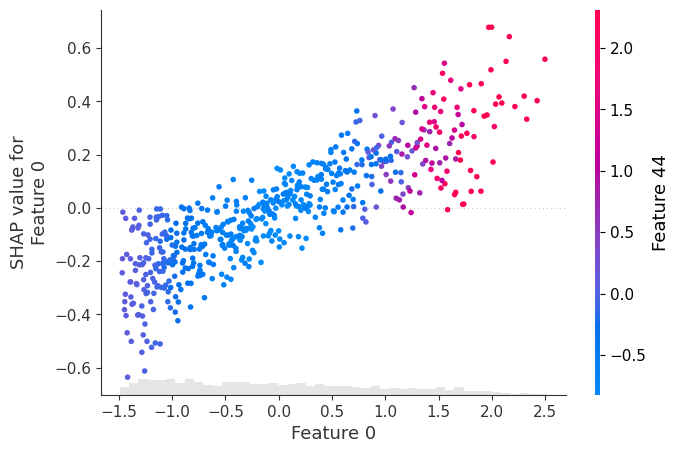

In [14]:
shap.plots.scatter(shap_values[:, 0], color=shap_values)

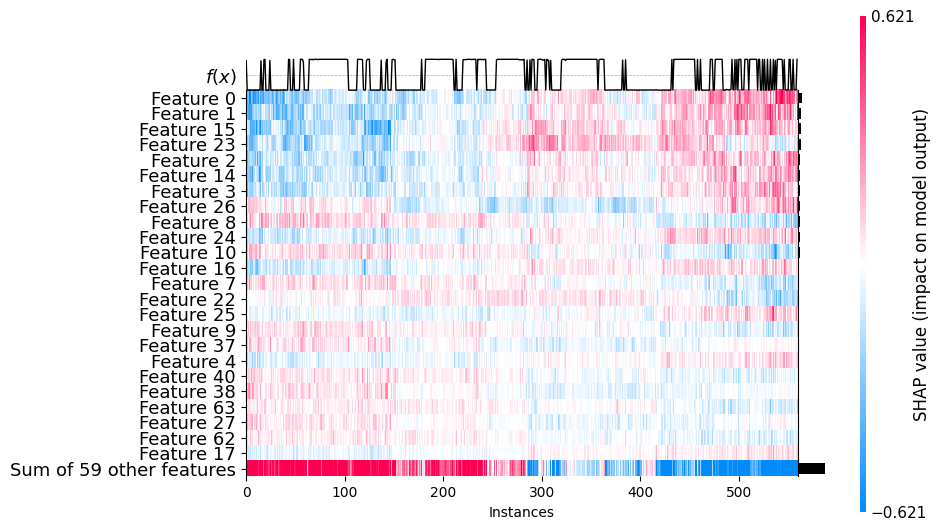

<Axes: xlabel='Instances'>

In [15]:
shap.plots.heatmap(shap_values[:1000], max_display=25)

### Testing the NNs

In [16]:
#Function for the probability of classification as LCDM 
def normFeat(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Function for the probability of classification as Feature 
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [17]:
#-----------------------------------------------------------------------------------------------------------
#Test the NN
#-----------------------------------------------------------------------------------------------------------
theory = ['LCDM','FT']

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(X_test)):
  X_test_tf = tf.convert_to_tensor([X_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normFeat(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))

1/1 [==============================] - 0s 29ms/step


### Performance verification of the NNs

In [18]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM MoG
True  0.5 0.5
False 0.0 0.0
--------------
Correct prediction:  1.0
Wrong prediction  :  0.0
